模拟数据集中的动作,就是传统的深度学习而已

In [ ]:
import torch


#封装数据集
class Dataset(torch.utils.data.Dataset):

    def __init__(self):
        import numpy as np
        data = np.loadtxt('conti_dataset.txt')
        self.state = torch.FloatTensor(data[:, :3])
        self.action = torch.FloatTensor(data[:, -1]).reshape(-1, 1)

    def __len__(self):
        return len(self.state)

    def __getitem__(self, i):
        return self.state[i], self.action[i]


dataset = Dataset()

len(dataset), dataset[0]

(20000, (tensor([ 0.4413,  0.8974, -0.7139]), tensor([-1.0650])))

In [2]:
#数据加载器
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=8,
                                     shuffle=True,
                                     drop_last=True)

len(loader), next(iter(loader))

(2500,
 [tensor([[-3.5129e-01, -9.3627e-01,  7.7210e+00],
          [ 9.7238e-01,  2.3339e-01, -1.8162e-01],
          [ 9.8686e-01, -1.6160e-01, -1.4199e+00],
          [-8.1516e-02, -9.9667e-01, -4.8387e+00],
          [ 9.7396e-01,  2.2673e-01, -4.5555e-03],
          [ 6.7717e-01, -7.3583e-01, -1.8038e+00],
          [-5.0408e-01, -8.6365e-01, -6.0765e+00],
          [ 1.5733e-02,  9.9988e-01, -6.0058e+00]]),
  tensor([[ 1.1108],
          [-0.4957],
          [ 0.5489],
          [-1.0889],
          [-0.5130],
          [ 0.4431],
          [-1.0646],
          [ 0.9083]])])

In [3]:
import torch

model = torch.nn.Sequential(
    torch.nn.Linear(3, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
    torch.nn.Tanh(),
)

model(torch.randn(2, 3)).shape

torch.Size([2, 1])

In [4]:
#训练
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(10):
        for i, (state, action) in enumerate(loader):
            out = model(state)

            loss = loss_fn(out, action)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 1 == 0:
            print(epoch, loss.item())


train()

0 0.0613434836268425
1 0.0868055447936058
2 0.14051637053489685
3 0.06583305448293686
4 0.02906099334359169
5 0.10832273960113525
6 0.06109079718589783
7 0.07594829797744751
8 0.04764041677117348
9 0.020972196012735367


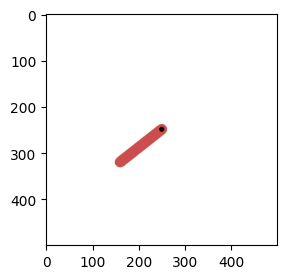

In [5]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(
            [action * 2])
        over = terminated or truncated

        #偏移reward,便于训练
        reward = (reward + 8) / 8

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [6]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model(torch.FloatTensor(state).reshape(1, 3)).item()

        #给动作添加噪声,增加探索
        action += random.normalvariate(mu=0, sigma=0.2)

        state, reward, over = env.step(action)
        reward_sum += reward

        if show:
            display.clear_output(wait=True)
            env.show()

    return reward_sum


#测试
sum([play() for _ in range(20)]) / 20

d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


161.67077983324688

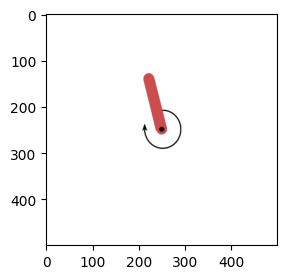

198.4692823345017

In [7]:
play(True)